# United Nations Sustainable Development Goal Indicator 6.6.1 : Water-related ecoystems

__Background:__ The United Nations Sustainable Development Goals include Target 6.6.1 : By 2020 protect and restore water-related ecosystems, including mountains, forests, wetlands, rivers, acquifers and lakes ([Indicator 6.6.1 : Change in the extent of water-related ecosystems over time](http://www.unwater.org/app/uploads/2018/05/Step-by-step-methodology-6-6-1_Revision-2018-03-02_Final.pdf)). This notebook demonstrates a workflow for calculating the change in vegetated wetlands and open waterbodies, a component of 6.6.1.  


__Requirements:__ You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an `issue` in the Github repository, or fix it yourself and create a `pull request` to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a pull request).

**Date:** November 2018

**Authors:** Bex Dunn, Robbi Bishop-Taylor, Sebastian Wong, Andrew Lem, Duncan Gray

### Import modules

In [1]:
import datacube
import geopandas as gpd
import numpy as np
import rasterio.mask
import rasterio.features
from shapely import geometry
import matplotlib.pyplot as plt
import sys
import xarray as xr
import numpy as np
import datetime
import pandas as pd

#These are dea-notebooks scripts https://github.com/GeoscienceAustralia/dea-notebooks
sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools, SpatialTools

dc = datacube.Datacube(app='tci and wofs')

%load_ext autoreload

%autoreload 2

### Import the coastline mask for removing open ocean from our dataset
Use the `GEODATA COAST 100K 2004` dataset (https://data.gov.au/dataset/geodata-coast-100k-2004) as a coarse approximation of the mean high water coastline to remove ocean from water layers
This is the mean high water mark (?)

<Figure size 432x288 with 0 Axes>

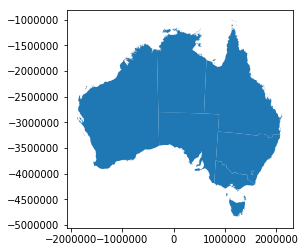

In [2]:
coastline_gpd = gpd.read_file('/g/data/r78/rt1527/datasets/Coastlines/australia/cstauscd_r.shp')
coastline_gpd = coastline_gpd.to_crs({'init': 'epsg:3577'})
coastline_gpd = coastline_gpd[(coastline_gpd.FEAT_CODE == 'island') | (coastline_gpd.FEAT_CODE == 'mainland')]
plt.clf()
coastline_gpd.plot()

### Load WOfS to get extent of open water
We have four test areas available in this notebook.
The areas are the Coorong/Murray Mouth, Mangroves in North-East QLD, Arafura swamp, and Menindee Lakes

In [3]:
resolution = 50

# ## Mangrove site
# query = dict(x=(149.84, 150.05),
#          y=(-22.14, -22.38),
#          resolution=(-resolution, resolution),
#          output_crs='EPSG:3577',
#          time=('2013-01-01', '2014-12-31'))

# ## Coorong
query = dict(x=(138.75, 139.03), 
             y=(-35.41, -35.59),
             resolution=(-resolution, resolution),
             output_crs='EPSG:3577',
             time=('2001-01-01', '2019-01-01'))

# # Menindee
# query = dict(x=(143.92, 144.14), 
#              y=(-31.35, -31.53), 
#              resolution=(-resolution, resolution),
#              output_crs='EPSG:3577',
# #              time=('2001-01-01', '2017-12-31'))

# # Arafura swamp
# query = dict(x=(134.867839, 135.251071), 
#              y=(-12.430335, -12.729316), 
#              resolution=(-resolution, resolution),
#              output_crs='EPSG:3577',
#              time=('2001-01-01', '2017-12-31'))

# # Mangroves
wofs_ds = dc.load(product='wofs_annual_summary', **query)

# Set nodata
wofs_ds = wofs_ds.where(wofs_ds.frequency != -1)


### Use the coastline to mask out the open ocean

In [4]:
# Create shoreline mask
coastline_mask = rasterio.features.geometry_mask(coastline_gpd.geometry,
                                                 out_shape=wofs_ds.geobox.shape,
                                                 transform=wofs_ds.geobox.affine,
                                                 all_touched=False, invert=True)

### Plot permanent water 

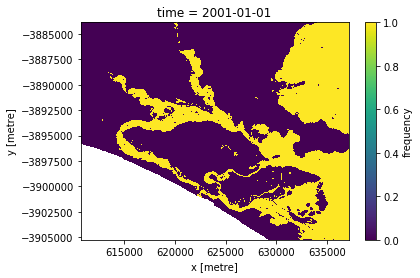

In [ ]:
perm_water = (wofs_ds.frequency > 0.9).where(coastline_mask)
perm_water.isel(time=0).plot()

### calculate area of permanent open water per year

Text(0.5, 0, 'time (years)')

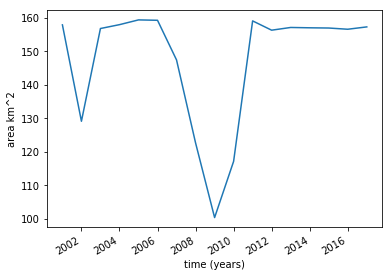

In [ ]:
pixel_km2 = (resolution * resolution) / (1000 * 1000)
perm_water_sum =(perm_water.sum(dim=['x', 'y']) * pixel_km2)
perm_water_sum.plot()
plt.ylabel('area km^2')
plt.xlabel('time (years)')

### Load in all Landsat data

In [ ]:
ls_data = DEADataHandling.load_clearlandsat(dc, 
                                            query, 
                                            sensors=('ls5', 'ls7', 'ls8'), 
                                            masked_prop=0,
                                            mask_pixel_quality=True)

Loading ls5 pixel quality
    Loading 114 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 46 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 125 filtered ls8 timesteps


### Make annual summaries of the wet and green tasselled cap data

In [ ]:
# Define unique years to analyse
years = np.unique(ls_data.time.dt.year)

#make empty list to hold vegetated wetlands
tc_yearly = []

#calculate vegetated wetland extent per year
for year in years:
    
    #select data from each year
    year_data = ls_data.sel(time=ls_data['time.year']==year) 
    
    # Apply tasseled cap transformation 
    tc_data = TasseledCapTools.pct_exceedance_tasseled_cap(year_data)
    
    #calculate 90th percentile of tasselled cap
    tc_data_90th = xr.where(tc_data>0.9, 1, 0)
    
    #select areas where wetness and greenness are both in  the 90th percentile
    wet_veg = xr.where((tc_data_90th.greenness_pct_exceedance & tc_data_90th.wetness_pct_exceedance),1,0)
    
    # So we can plot the yearly data easily, re-add the time dimension to the wet veg array
    wet_veg['time'] = year
    wet_veg = wet_veg.expand_dims('time')
    
    # Append yearly result to list
    tc_yearly.append(wet_veg)

    

In [ ]:
# Combine all individual years into one xarray dataset
wet_veg_yearly = xr.concat(tc_yearly, dim='time') 

# Plot multiple years of data
wet_veg_yearly.plot(col='time', col_wrap=4, cmap='YlGn_r')

In [ ]:
sdg_661_df= wet_veg_yearly.sum(dim=['x', 'y']).to_dataframe(name='perm_wetveg_pixels')
sdg_661_df['perm_wetveg_km2'] = sdg_661_df['perm_wetveg_pixels'] * pixel_km2
sdg_661_df = sdg_661_df.drop(columns='perm_wetveg_pixels')
sdg_661_df['perm_openwater_km2'] = perm_water_sum[perm_water_sum['time.year'].isin(years)] 
sdg_661_df

In [ ]:
plt.plot(sdg_661_df['perm_wetveg_km2'])
plt.plot(sdg_661_df['perm_openwater_km2'])

In [ ]:
sdg_661_df[['perm_openwater_km2', 'perm_wetveg_km2']].plot.area(figsize=(10, 5), color=['xkcd:ocean blue', 'xkcd:lightish green'], alpha=0.7)

In [ ]:

    
    
    
#     # Prepare attributes as input to contour extract
#     attribute_data = {'in_perc': [area]}
#     attribute_dtypes = {'in_perc': 'float'}
    
#     # Set threshold
#     thresh = 0

#     # Extract contours with custom attribute fields:
#     contour_dict = contour_extract(z_values=[thresh],
#                                    ds_array=cleaned_subset_i.mndwi,
#                                    ds_crs='epsg:3577',
#                                    ds_affine=landsat_dataset.geobox.transform,
#                                    output_shp='relative_topography/{}_{}.shp'.format(name, i),
#                                    min_vertices=50,  
#                                    attribute_data=attribute_data,
#                                    attribute_dtypes=attribute_dtypes)    

    
    
# # Combine all shapefiles into one file
# shapefiles = glob.glob('relative_topography/{}_*.shp'.format(name))
# gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles], sort=False).pipe(gpd.GeoDataFrame)

# # Save as combined shapefile
# gdf = gdf.reset_index()[['in_perc', 'geometry']].sort_values('in_perc')
# gdf.crs = 'epsg:3577'
# gdf.to_file(f'relative_topography/{name}_combined.shp')

# # Plot contours
# fig, ax = plt.subplots(figsize=(16, 16))
# gdf.plot(ax=ax, column='in_perc', cmap='viridis')
